# Irradiated Monkeys Cont.
In this notebook I will elaborte on the work with the A_monkeys_preliminary findings

Specifically, I will focus on the following:


1.) Predicting aspects of the monkey's biomarkers and health outcomes with reducted and critical features
   
   - a.) Using regression predictions instead of classification for continuous variables
   
   - b.) Predicting single monkey data based on a model trained on multi monkey data, and vise versa
   
   - c.) Predicting using only top 5 most important features
   
   - d.) Predicting using only irradiation data
   
   - e.) Predicting dose exposure
   
   
2.) Clustering the data through other methods

3.) Combining the biomarker and health-outcome data in more complex ways 

4.) Utilizing dimentionality reduction for vizualization and training

5.) Automate the cycling through of predictions

In [47]:
### Using monkey_env/ ###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

print("Setup Complete")


Setup Complete


In [48]:
pwd

'/Users/aidanlew/Documents'

In [49]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [50]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Regression, forcasting, & clustering

## 1.a.) Regression prediction for continuous variables

## Data loading

In [92]:
# Make a df of the binary health data of the monkeys
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

minhealth_monkey_df['Animal_Status'] = minhealth_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})
minhealth_monkey_df.head(15)

,ID,Time_Under_Observation_(yrs),Dose_(Gy),Irrad_Age_(months),Years_Since_Irrad,Current_Age_(years),Animal_Status,Diabetes_(Y/N),Cataracts_(Y/N),Arthritis_(Y/N),...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,1423,1.380822,0.00,NaN,NaN,9.947945,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1484,11.868493,0.00,NaN,NaN,19.276712,1,0,1,1,...,0,0,0,0,0,1,0,1,0,0
2,1574,13.030137,7.55,52.9,13.358904,17.767123,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,1575,14.139726,7.85,40.2,14.372603,17.726027,0,0,1,1,...,1,1,0,0,1,1,0,0,0,1
4,1576,6.394521,8.05,51.4,6.723288,11.005479,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
5,1577,12.109589,7.55,37.0,12.438356,15.520548,0,1,1,1,...,1,1,0,0,1,0,0,1,0,1
6,1578,11.682192,7.20,39.4,12.010959,15.295890,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
7,1597,15.501370,8.40,52.9,15.868493,20.273973,1,0,1,0,...,1,1,0,0,1,1,0,0,0,1
8,1611,11.712329,7.55,46.4,12.090411,15.961644,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0
9,1612,11.846575,6.75,84.2,12.147945,19.161644,0,1,0,1,...,1,1,0,1,1,1,0,1,0,0


In [93]:
#Makee a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

#minbio_monkey_df.columns
minbio_monkey_df.tail()


Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4547,2112,Rhesus-Chinese,2020-09-23,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4548,2112,Rhesus-Chinese,2021-03-04,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4549,2210,Rhesus-Indian,2021-09-07,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4550,2210,Rhesus-Indian,2021-09-20,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4551,2210,Rhesus-Indian,2021-10-07,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [94]:
#Makee a df were there is one monkey's data missing (the same in the single_monkey_df)
oneless_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
oneless_df.set_index(['ID'])

oneless_df['ID'] = oneless_df['ID'].astype(str)

#oneless_dff.dropna(axis=0, inplace=True) 

#oneless_df.columns
oneless_df.tail()

Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4529,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4530,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4531,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [95]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


### Single Monkey

#### Data processing for ML

In [55]:
#make a parent df
single_minbio_df.copy()
sreg_df = single_minbio_df
#sreg_df.tail(2)

#make train/testdf
(sreg_train_df, sreg_test_df)= sreg_df, sreg_df

#sreg_test_df.tail(2)

# label values extraction
sreg_y=sreg_train_df['LYMPHOCYTES_(%)']
sreg_X=sreg_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)

#sreg_y.tail()
#sreg_X.columns

#sreg_y.to_numpy()

# Declare catagorical features - first column
cat_features= list(range(0,sreg_X[sreg_X.columns[:4]].shape[1]))

print(cat_features)

# all of our labels are catagorical

[0, 1, 2, 3]


In [56]:
from catboost import Pool
from sklearn.model_selection import train_test_split

#put the data into the pool
sreg_pool = Pool(data=sreg_X, label=sreg_y, cat_features=cat_features)


#train tesr split - 30% test
sreg_data= train_test_split(sreg_X, sreg_y, test_size=0.3, random_state=0)

#### The order of this matters###
sreg_X_train, sreg_X_validation,sreg_y_train, sreg_y_validation= sreg_data

sreg_train_pool = Pool(
    data = sreg_X_train,
    label = sreg_y_train,
    cat_features = cat_features
)

sreg_validation_pool = Pool(
    data = sreg_X_validation,
    label = sreg_y_validation,
    cat_features = cat_features
)


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [57]:
from catboost import CatBoostRegressor

# Model for predicting lymphocyte counts for a singel monkey
model7= CatBoostRegressor(iterations=10,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
                        
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)


model7.fit(sreg_X, 
           sreg_y, 
           cat_features=cat_features,
           #plot=True,
           verbose=100 #tells how many iterations to print
         )

####1000 iter gives R2=1
###1 iter gives R2=0.057
###2 iters gives R2=0.51
###3 iters gives R2=0.65
###4 iters gives R2=0.81
###10 iters gives r2=0.99

0:	learn: 11.2460441	total: 670us	remaining: 6.03ms
9:	learn: 2.4032194	total: 5.64ms	remaining: 0us


#### Predictions

In [58]:
from sklearn.metrics import r2_score
#Predict the test Lymphocyte percentages

sreg_a = model7.predict(sreg_X_validation)
print(len(sreg_a), 
     )
sreg_a_df = pd.DataFrame(sreg_a)
print(sreg_a_df)
print(sreg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
print('The r2 score for the model is:',r2_score(sreg_y_validation, sreg_a_df))


6
           0
0  39.671566
1  34.189990
2  22.662013
3  20.551448
4  38.130019
5  23.762847
34    40.5
39    35.1
41    21.8
43    20.1
47    38.2
37    22.8
Name: LYMPHOCYTES_(%), dtype: float64
The r2 score for the model is: 0.9919249270480266


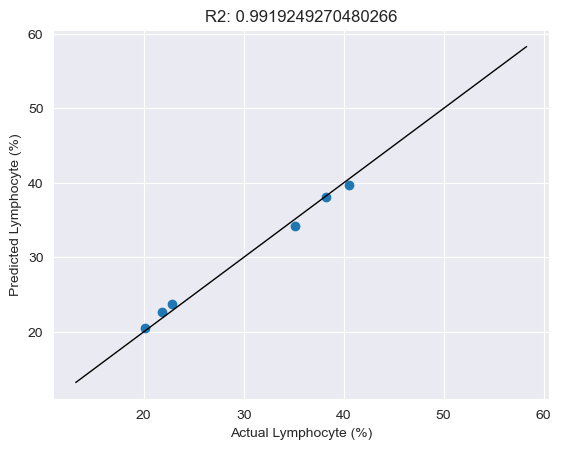

In [59]:
# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(sreg_y_validation, sreg_a_df)


ax.plot([sreg_y.min(), sreg_y.max()], [sreg_y.min(), sreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')

#regression line
#sreg_y_validation, sreg_a_df = sreg_y_validation.reshape(-1,1), sreg_a_df.reshape(-1,1)
#ax.plot(sreg_y_validation, LinearRegression().fit(sreg_y_validation, sreg_a_df).predict(sreg_y_validation))



ax.set_title('R2: ' + str(r2_score(sreg_y_validation, sreg_a_df)))


plt.show()

#### Feature importance

In [60]:
# Find the feature importance for predicting the lmphocyte counts is a single monkey
model7.get_feature_importance(data=sreg_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)


,Feature Id,Importances
0,NEUT_(%),25.791263
1,TYPE,13.162456
2,ABS_LYMPH_(/uL),13.094777
3,EOS_(%),11.994731
4,RBC_(M/uL),11.799281
5,Hemocrit_(HCT_%),4.794531
6,Mean_corpuscular_hemaglobin_concentration_(MCH...,4.392843
7,MONTHS_SINCE_IRRAD,3.730368
8,WBC_(K/uL),3.359482
9,ABS_NEUT_(/uL),2.996981


### Multi Monkey

#### Data processing for ML

In [61]:
#make a parent df
minbio_monkey_df.copy()
mreg_df = minbio_monkey_df
#sreg_df.tail(2)

#make train/testdf
(mreg_train_df, mreg_test_df)= mreg_df, mreg_df

#mreg_test_df.tail(2)

# label values extraction
mreg_y=mreg_train_df['LYMPHOCYTES_(%)']
mreg_X=mreg_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)

#mreg_y.tail()
#mreg_X.columns

#mreg_y.to_numpy()

# Declare catagorical features - first column
cat_features= list(range(0,mreg_X[mreg_X.columns[:4]].shape[1]))


print(cat_features)

# all of our labels are catagorical

[0, 1, 2, 3]


In [62]:
#put the data into the pool
mreg_pool = Pool(data=mreg_X, label=mreg_y, cat_features=cat_features)


#train tesr split - 30% test
mreg_data= train_test_split(mreg_X, mreg_y, test_size=0.3, random_state=0)

#### The order of this matters###
mreg_X_train, mreg_X_validation,mreg_y_train, mreg_y_validation= mreg_data

mreg_train_pool = Pool(
    data = mreg_X_train,
    label = mreg_y_train,
    cat_features = cat_features
)

mreg_validation_pool = Pool(
    data = mreg_X_validation,
    label = mreg_y_validation,
    cat_features = cat_features
)


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [63]:
# rEgression for multiple monkey predicitons
model8= CatBoostRegressor(iterations=10
                          ,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model8.fit(mreg_X, 
           mreg_y, 
           cat_features=cat_features, 
          # verbose=100 #tells how many iterations to print
         )
### 200 iters takes 3 seconds and gives 0.2436142 loss
### 1000 iters takes 12 seconds and gives 0.0214503 loss
### 10000 iters takes 1.5 min and has 2.8X10^-6 loss 

#### 200 gives very accurate results for predicting lymphocyte %
### 100 gives R2 of almost 1
# 10 iterations gives R2 of 0.98
# 1 iteration gives R2 of 0.65!!!
# 2 iterations gives R2 of 0.86!!!!!

0:	learn: 8.9546285	total: 5.29ms	remaining: 47.6ms
1:	learn: 5.6638343	total: 8.65ms	remaining: 34.6ms
2:	learn: 4.0121201	total: 12ms	remaining: 28.1ms
3:	learn: 3.0209193	total: 15.8ms	remaining: 23.8ms
4:	learn: 2.5326614	total: 18.9ms	remaining: 18.9ms
5:	learn: 2.2299779	total: 21.8ms	remaining: 14.5ms
6:	learn: 2.0293479	total: 24.9ms	remaining: 10.7ms
7:	learn: 1.9160268	total: 28ms	remaining: 6.99ms
8:	learn: 1.8753615	total: 32.6ms	remaining: 3.62ms
9:	learn: 1.7568019	total: 36.2ms	remaining: 0us


#### Predictions

In [64]:
#Predict the test Lymphocyte percentages

mreg_a = model8.predict(mreg_X_validation)
print(len(mreg_a), 
     )
mreg_a_df = pd.DataFrame(mreg_a)
print(mreg_a_df)
print(mreg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
print('The r2 score for the model is:',r2_score(mreg_y_validation, mreg_a_df))


1366
              0
0     19.774720
1     33.581875
2     34.684135
3     11.069925
4     61.795744
...         ...
1361  46.202982
1362  40.846701
1363  12.598577
1364  45.180812
1365  42.727875

[1366 rows x 1 columns]
2438    17.9
3343    36.1
1895    36.0
3501    10.2
3256    61.1
        ... 
3878    49.0
3037    39.0
4250    15.3
1770    46.4
2735    44.1
Name: LYMPHOCYTES_(%), Length: 1366, dtype: float64
The r2 score for the model is: 0.9871703342291999


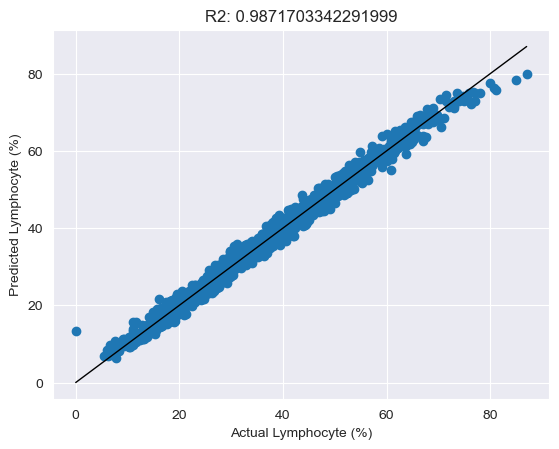

In [65]:
# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(mreg_y_validation, mreg_a_df)


ax.plot([mreg_y.min(), mreg_y.max()], [mreg_y.min(), mreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(mreg_y_validation, mreg_a_df)))


plt.show()

#### Feature Analysis

In [66]:
# Find the feature importance for predicting the lmphocyte counts is a single monkey
model8.get_feature_importance(data=mreg_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)


,Feature Id,Importances
0,NEUT_(%),86.690265
1,ABS_LYMPH_(/uL),4.309505
2,ABS_MONO_(/uL),2.908496
3,MONO_(%),2.536824
4,EOS_(%),1.749061
5,ABS_EOS_(/uL),0.948118
6,Hemaglobin_(HGB_g/dL),0.429481
7,ABS_NEUT_(/uL),0.275921
8,Hemocrit_(HCT_%),0.072630
9,Mean_corpuscular_volume_(MCV_fL),0.037872


### Summary
Using Regression for predicitng values generates more accurate (based on iterations) and much quiker results compared to classifier. It is interesting how the feature importance does change a little though. Even with all the biological data, only 2 iterations gives R2=0.86 which is absolutely insane. I think this is probably due to the amount of data. This is very promising for the power of these models and the scalability of the applications. But super easy to overfit.

## 1.b.) Prediction of different data
- Using the multi monkey model to predict the single monkey data and vise versa
- Using just the top 5 features to make the models and make the predicitons
- See if using irrad data only can make accurate predictions
- How to make predictions of different features withthout making a new model every time???

Note: see if there is a way to streamline this process - pipelines?

### A. Predicting the single monkey lymphocytes using the multi-monkey model

6


iteritems is deprecated and will be removed in a future version. Use .items instead.


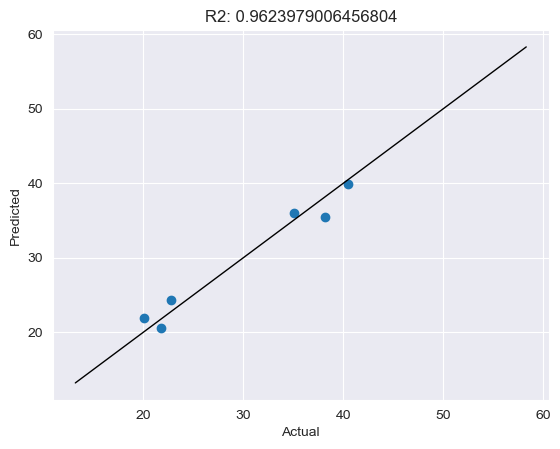

In [67]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 2 iteration, 0.5 learning rate

smreg_a = model8.predict(sreg_X_validation)
print(len(smreg_a), 
     )
smreg_a_df = pd.DataFrame(smreg_a)
#print(smreg_a_df)
#print(sreg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
#print('The r2 score for the model is:',r2_score(sreg_y_validation, smreg_a_df))

# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(sreg_y_validation, smreg_a_df)


ax.plot([sreg_y.min(), sreg_y.max()], [sreg_y.min(), sreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(sreg_y_validation, smreg_a_df)))

plt.show()

### B. Predicting the multi-monkey lymphocytes using the single-monkey model

iteritems is deprecated and will be removed in a future version. Use .items instead.


1366


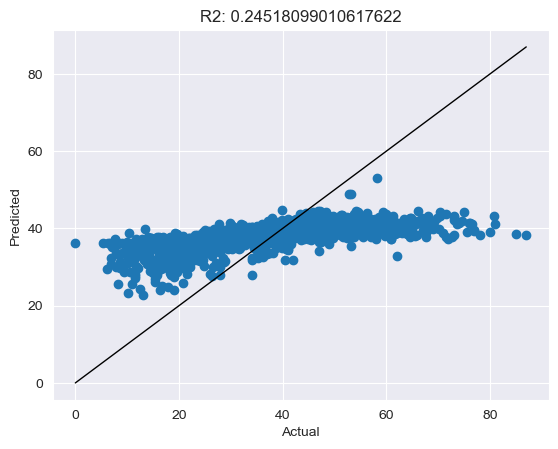

In [68]:
### Predicting if the apropriately fitted single monkey model can predict the multi mokey lymphocytes
## 4 iteration, 0.5 learning rate
msreg_a = model7.predict(mreg_X_validation)
print(len(msreg_a), 
     )
msreg_a_df = pd.DataFrame(msreg_a)
#print(msreg_a_df)
#print(mreg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
#print('The r2 score for the model is:',r2_score(mreg_y_validation, msreg_a_df))

# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(mreg_y_validation, msreg_a_df)


ax.plot([mreg_y.min(), mreg_y.max()], [mreg_y.min(), mreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(mreg_y_validation, msreg_a_df)))

plt.show()

In [69]:
### Seeing if more iterations will better predict the multi monkey data
# Model for predicting lymphocyte counts for a singel monkey
model9= CatBoostRegressor(iterations=100000,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)


model9.fit(sreg_X, 
           sreg_y, 
           cat_features=cat_features,
           #plot=True,
           verbose=10000 #tells how many iterations to print
         )

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 11.2460441	total: 879us	remaining: 1m 27s
10000:	learn: 0.0000000	total: 3.53s	remaining: 31.8s
20000:	learn: 0.0000000	total: 7.18s	remaining: 28.7s
30000:	learn: 0.0000000	total: 10.8s	remaining: 25.2s
40000:	learn: 0.0000000	total: 14.5s	remaining: 21.7s
50000:	learn: 0.0000000	total: 18.3s	remaining: 18.3s
60000:	learn: 0.0000000	total: 21.8s	remaining: 14.5s


KeyboardInterrupt: 

In [ ]:
### Predicting the multi monkey lymphocytes using the single monkey overfitted model
## 100000 iteration, 0.5 learning rate


msreg_a = model9.predict(mreg_X_validation)
print(len(msreg_a), 
     )
msreg_a_df = pd.DataFrame(msreg_a)
#print(msreg_a_df)
#print(mreg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
#print('The r2 score for the model is:',r2_score(mreg_y_validation, msreg_a_df))

# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(mreg_y_validation, msreg_a_df)


ax.plot([mreg_y.min(), mreg_y.max()], [mreg_y.min(), mreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(mreg_y_validation, msreg_a_df)))

plt.show()

### C. Predictions using only the top 5 important features
top 5 features found in section 1.a. Using the top 5 features found from each model (single v. multi monkey)

### Single Monkey:
Top 5 features: 
- 0 NEUT_(%)	26.502043
- 1	TYPE	12.952220
- 2	ABS_LYMPH_(/uL)	12.820068
- 3	EOS_(%)	11.754037
- 4	RBC_(M/uL)	11.554449


#### Data Processing

In [70]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
sred_reg_df = single_minbio_df[['ID', 'TYPE', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','RBC_(M/uL)', 'LYMPHOCYTES_(%)']]
sred_reg_df.tail(2)


,ID,TYPE,NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),RBC_(M/uL),LYMPHOCYTES_(%)
49,2046,Clinical,36.9,5130,0.2,6.55,58.3
50,2046,Research,45.9,3897,0.3,5.56,52.8


In [71]:
### Process data for ML
#make train/testdf
(sred_reg_train_df, sred_reg_test_df)= sred_reg_df, sred_reg_df

#sreg_test_df.tail(2)

# label values extraction
sred_reg_y=sred_reg_train_df['LYMPHOCYTES_(%)']
sred_reg_X=sred_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

#reg_y.tail()
#sred_reg_X.columns

#sred_reg_y.to_numpy()

# Declare catagorical features - first column
cat_features= list(range(0,sred_reg_X[sred_reg_X.columns[:1]].shape[1]))

print(cat_features)

# all of our labels are catagorical

#put the data into the pool
sred_reg_pool = Pool(data=sred_reg_X, label=sred_reg_y, cat_features=cat_features)


#train tesr split - 30% test
sred_reg_data= train_test_split(sred_reg_X, sred_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
sred_reg_X_train, sred_reg_X_validation, sred_reg_y_train, sred_reg_y_validation= sred_reg_data

sred_reg_train_pool = Pool(
    data = sred_reg_X_train,
    label = sred_reg_y_train,
    cat_features = cat_features
)

sred_reg_validation_pool = Pool(
    data = sred_reg_X_validation,
    label = sred_reg_y_validation,
    cat_features = cat_features
)



[0]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [72]:
### Making a model with the same perameters but with only the top 5 important features
# rEgression for multiple monkey predicitons
model10= CatBoostRegressor(iterations=4,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model10.fit(sred_reg_X, 
           sred_reg_y, 
           cat_features=cat_features, 
          # verbose=100 #tells how many iterations to print
         )


0:	learn: 10.8658171	total: 224us	remaining: 672us
1:	learn: 8.3596623	total: 406us	remaining: 406us
2:	learn: 7.1663548	total: 637us	remaining: 212us
3:	learn: 6.1039802	total: 1.39ms	remaining: 0us


#### Predictions

6


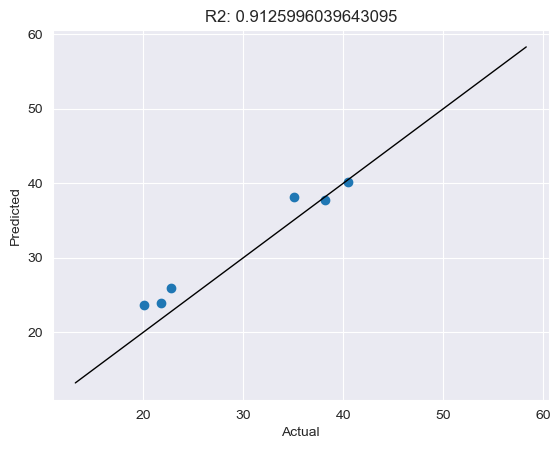

In [73]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 2 iteration, 0.5 learning rate

sred_reg_a = model10.predict(sred_reg_X_validation)
print(len(sred_reg_a), 
     )
sred_reg_a_df = pd.DataFrame(sred_reg_a)
#print(sred_reg_a_df)
#print(sred_reg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
#print('The r2 score for the model is:',r2_score(sreg_y_validation, smreg_a_df))

# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(sred_reg_y_validation, sred_reg_a_df)


ax.plot([sred_reg_y.min(), sred_reg_y.max()], [sred_reg_y.min(), sred_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(sred_reg_y_validation, sred_reg_a_df)))

plt.show()

### Multi Monkey
Top 5 features:
- 0 NEUT_(%)	92.324836
- 1	ABS_LYMPH_(/uL)	3.185803
- 2	ABS_MONO_(/uL)	2.682848
-  3	EOS_(%)	1.198216
- 4	Hemaglobin_(HGB_g/dL)	0.559005

Also try with just NEUT_(%) since it is so heavily weighted

#### Data Processing

In [74]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mred_reg_df = minbio_monkey_df[['ID', 'ABS_MONO_(/uL)', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','Hemaglobin_(HGB_g/dL)', 'LYMPHOCYTES_(%)']]
mred_reg_df.tail(2)


,ID,ABS_MONO_(/uL),NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),Hemaglobin_(HGB_g/dL),LYMPHOCYTES_(%)
4550,2210,632,51.2,2100,1.7,13.2,36.2
4551,2210,1176,60.0,896,3.0,13.2,16.0


In [75]:
### Process data for ML
#make train/testdf
(mred_reg_train_df, mred_reg_test_df)= mred_reg_df, mred_reg_df


# label values extraction
mred_reg_y=mred_reg_train_df['LYMPHOCYTES_(%)']
mred_reg_X=mred_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,mred_reg_X[mred_reg_X.columns[:1]].shape[1]))

print(cat_features)


#put the data into the pool
mred_reg_pool = Pool(data=mred_reg_X, label=mred_reg_y, cat_features=cat_features)


#train tesr split - 30% test
mred_reg_data= train_test_split(mred_reg_X, mred_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
mred_reg_X_train, mred_reg_X_validation, mred_reg_y_train, mred_reg_y_validation= mred_reg_data

mred_reg_train_pool = Pool(
    data = mred_reg_X_train,
    label = mred_reg_y_train,
    cat_features = cat_features
)

mred_reg_validation_pool = Pool(
    data = mred_reg_X_validation,
    label = mred_reg_y_validation,
    cat_features = cat_features
)



[0]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [76]:
### Making a model with the same perameters but with only the top 5 important features
# regression for multiple monkey predicitons
model11= CatBoostRegressor(iterations=2,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model11.fit(mred_reg_X, 
           mred_reg_y, 
           cat_features=cat_features, 
          # verbose=100 #tells how many iterations to print
         )


0:	learn: 9.0561659	total: 2.12ms	remaining: 2.12ms
1:	learn: 5.6939955	total: 3.92ms	remaining: 0us


#### Predicting multi-monkey lymphocytes

1366


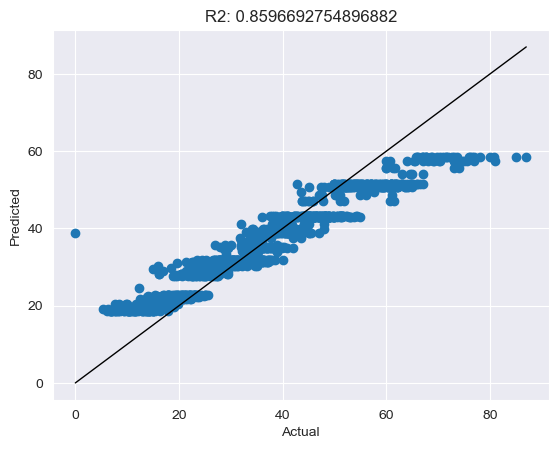

In [77]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 2 iteration, 0.5 learning rate

mred_reg_a = model11.predict(mred_reg_X_validation)
print(len(mred_reg_a), 
     )
mred_reg_a_df = pd.DataFrame(mred_reg_a)
#print(sred_reg_a_df)
#print(sred_reg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
#print('The r2 score for the model is:',r2_score(sreg_y_validation, smreg_a_df))

# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(mred_reg_y_validation, mred_reg_a_df)


ax.plot([mred_reg_y.min(), mred_reg_y.max()], [mred_reg_y.min(), mred_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(mred_reg_y_validation, mred_reg_a_df)))

plt.show()

#### Predicting single-monkey lymphocytes
Needs the same features to directly compare

In [78]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 2 iteration, 0.5 learning rate

smred_reg_a = model11.predict(sred_reg_X_validation)
print(len(smred_reg_a), 
     )
smred_reg_a_df = pd.DataFrame(smred_reg_a)
#print(sred_reg_a_df)
#print(sred_reg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
#print('The r2 score for the model is:',r2_score(sreg_y_validation, smreg_a_df))

# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(sred_reg_y_validation, smred_reg_a_df)


ax.plot([sred_reg_y.min(), sred_reg_y.max()], [sred_reg_y.min(), sred_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(sred_reg_y_validation, smred_reg_a_df)))

plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 4 should be feature with name Hemaglobin_(HGB_g/dL) (found RBC_(M/uL)).

### D. Predicting lymphocytes with only the irradiation data


#### Multi Monkey only
No variation for single monkey model formation

##### Data processing

In [79]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mrad_reg_df = minbio_monkey_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
mrad_reg_df.tail(2)


,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
4550,2210,No,F,NaN,NaN,NaN,NaN,25.5,36.2
4551,2210,No,F,NaN,NaN,NaN,NaN,22.8,16.0


In [80]:
### Process data for ML
#make train/testdf
(mrad_reg_train_df, mrad_reg_test_df)= mrad_reg_df, mrad_reg_df


# label values extraction
mrad_reg_y=mrad_reg_train_df['LYMPHOCYTES_(%)']
mrad_reg_X=mrad_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,mrad_reg_X[mrad_reg_X.columns[:2]].shape[1]))

print(cat_features)


#put the data into the pool
mrad_reg_pool = Pool(data=mrad_reg_X, label=mrad_reg_y, cat_features=cat_features)


#train tesr split - 30% test
mrad_reg_data= train_test_split(mrad_reg_X, mrad_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
mrad_reg_X_train, mrad_reg_X_validation, mrad_reg_y_train, mrad_reg_y_validation= mrad_reg_data

mrad_reg_train_pool = Pool(
    data = mrad_reg_X_train,
    label = mrad_reg_y_train,
    cat_features = cat_features
)

mrad_reg_validation_pool = Pool(
    data = mrad_reg_X_validation,
    label = mrad_reg_y_validation,
    cat_features = cat_features
)



[0, 1]


iteritems is deprecated and will be removed in a future version. Use .items instead.


##### Model Formation

In [81]:
### Making a model with the same perameters but with only the top 5 important features
# regression for multiple monkey predicitons
model12= CatBoostRegressor(iterations=1000,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model12.fit(mrad_reg_X, 
           mrad_reg_y, 
           cat_features=cat_features, 
           verbose=100 #tells how many iterations to print
         )
### 2 iters gives R2 = 0.12
### 10 iters gives R2 = 0.2
### 100 iters gives R2 = 0.4
### 1000 iters gives R2 = 0.73

0:	learn: 14.8524382	total: 2.48ms	remaining: 2.48s
100:	learn: 11.4650605	total: 364ms	remaining: 3.24s
200:	learn: 10.4762500	total: 499ms	remaining: 1.98s
300:	learn: 9.8396659	total: 621ms	remaining: 1.44s
400:	learn: 9.3452165	total: 726ms	remaining: 1.08s
500:	learn: 8.9539214	total: 825ms	remaining: 822ms
600:	learn: 8.6488356	total: 927ms	remaining: 615ms
700:	learn: 8.4305616	total: 1.03s	remaining: 439ms
800:	learn: 8.2397296	total: 1.13s	remaining: 280ms
900:	learn: 8.0563111	total: 1.23s	remaining: 135ms
999:	learn: 7.9163296	total: 1.34s	remaining: 0us


##### Predicting multi-monkey lymphocytes

1366


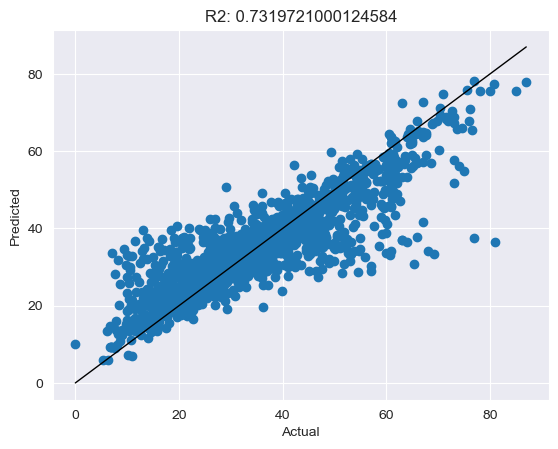

In [82]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 1000 iteration, 0.5 learning rate

mrad_reg_a = model12.predict(mrad_reg_X_validation)
print(len(mrad_reg_a), 
     )
mrad_reg_a_df = pd.DataFrame(mrad_reg_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(mrad_reg_y_validation, mrad_reg_a_df)


ax.plot([mrad_reg_y.min(), mrad_reg_y.max()], [mrad_reg_y.min(), mrad_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(mrad_reg_y_validation, mrad_reg_a_df)))

plt.show()

##### Predicting single-monkey lymphocytes

In [83]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
srad_reg_df = single_minbio_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
srad_reg_df.tail(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
49,2046,Yes,F,2570.0,84.0,81.0,1.14,13.8,58.3
50,2046,Yes,F,2738.0,90.0,81.0,1.14,14.3,52.8


In [84]:
### Process data for ML
#make train/testdf
(srad_reg_train_df, srad_reg_test_df)= srad_reg_df, srad_reg_df


# label values extraction
srad_reg_y=srad_reg_train_df['LYMPHOCYTES_(%)']
srad_reg_X=srad_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,srad_reg_X[srad_reg_X.columns[:2]].shape[1]))

print(cat_features)


#put the data into the pool
srad_reg_pool = Pool(data=srad_reg_X, label=srad_reg_y, cat_features=cat_features)


#train tesr split - 30% test
srad_reg_data= train_test_split(srad_reg_X, srad_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
srad_reg_X_train, srad_reg_X_validation, srad_reg_y_train, srad_reg_y_validation= srad_reg_data

srad_reg_train_pool = Pool(
    data = srad_reg_X_train,
    label = srad_reg_y_train,
    cat_features = cat_features
)

srad_reg_validation_pool = Pool(
    data = srad_reg_X_validation,
    label = srad_reg_y_validation,
    cat_features = cat_features
)



[0, 1]


iteritems is deprecated and will be removed in a future version. Use .items instead.


6


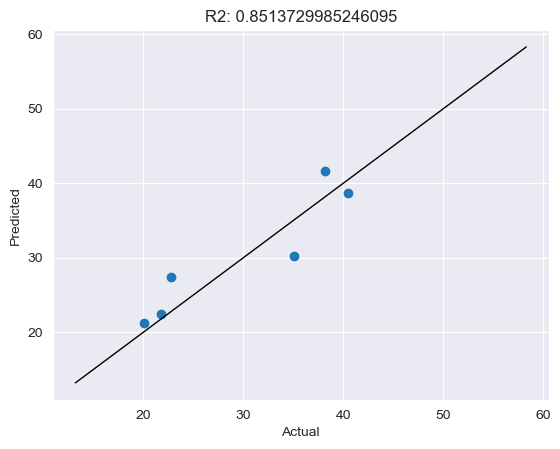

In [85]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 1000 iteration, 0.5 learning rate

smrad_reg_a = model12.predict(srad_reg_X_validation)
print(len(smrad_reg_a), 
     )
smrad_reg_a_df = pd.DataFrame(smrad_reg_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(srad_reg_y_validation, smrad_reg_a_df)


ax.plot([srad_reg_y.min(), srad_reg_y.max()], [srad_reg_y.min(), srad_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(srad_reg_y_validation, smrad_reg_a_df)))

plt.show()

### E. Predictions with data that excludes the individual
See if excluding the target individual from the dataset still gives accurate predictions

#### Data Processing

In [86]:
### setting up the multi monkey df without the single monkey 
oneless_df.tail(2)


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [87]:
### Processing the data for ML
### Process data for ML
#make train/testdf
(oneless_train_df, oneless_test_df)= oneless_df, oneless_df


# label values extraction
oneless_y=oneless_train_df['LYMPHOCYTES_(%)']
oneless_X=oneless_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,oneless_X[oneless_X.columns[:4]].shape[1]))

print(cat_features)


#put the data into the pool
oneless_pool = Pool(data=oneless_X, label=oneless_y, cat_features=cat_features)


#train tesr split - 30% test
oneless_data= train_test_split(oneless_X, oneless_y, test_size=0.3, random_state=0)

#### The order of this matters###
oneless_X_train, oneless_X_validation, oneless_y_train, oneless_y_validation= oneless_data

oneless_train_pool = Pool(
    data = oneless_X_train,
    label = oneless_y_train,
    cat_features = cat_features
)

oneless_validation_pool = Pool(
    data = oneless_X_validation,
    label = oneless_y_validation,
    cat_features = cat_features
)


[0, 1, 2, 3]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [88]:
### Making a model with the same perameters but without the single monkey data
# regression for multiple monkey predicitons
model13= CatBoostRegressor(iterations=2,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model13.fit(oneless_X, 
           oneless_y, 
           cat_features=cat_features, 
           verbose=100 #tells how many iterations to print
         )
### 2 iters gives R2 = 0.12


0:	learn: 9.6225247	total: 8.9ms	remaining: 8.9ms
1:	learn: 6.0610900	total: 15.3ms	remaining: 0us


#### Predictions
Just predicting the single monkey data in this case

6


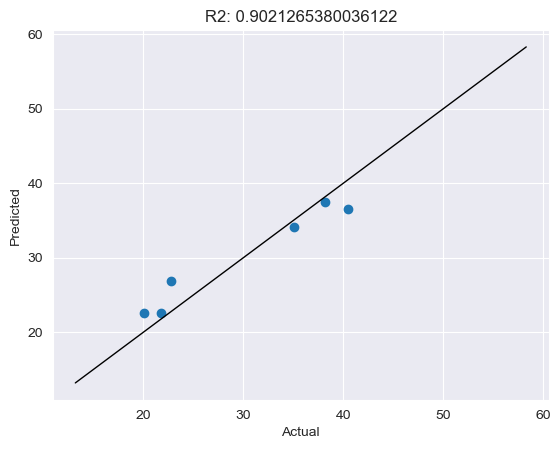

In [89]:
### Predicting the single monkey lymphocyte levels using the mult monkey minus single model
## 2 iteration, 0.5 learning rate

onless_a = model13.predict(sreg_X_validation)
print(len(onless_a), 
     )
onless_a_df = pd.DataFrame(onless_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(sreg_y_validation, onless_a_df)


ax.plot([sreg_y.min(), sreg_y.max()], [sreg_y.min(), sreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(sreg_y_validation, onless_a_df)))

plt.show()

### Summary
- A.) A single monkey's lymphocyte levels can be accurately predicted (R2=0.85) using the model trained on all the monkeys.
- B.) A single monkey's model does not accurately predict the other monkey's lymphocyte counts
- C.) Only using the top 5 important features for each model gives highly accurate predictions (R2=0.85-0.91) but the multi-monkey model was unable to predict the single monkey lymphocyte levels because the model needs the same features between the datasets and they were different (different top 5 features)
- D.) Only using the non-timeseries, radiation-related data was abel to accurately predict the multi-monkey lymphocyte levels (R2=0.73) and the single monkey lymphocyte levels (R2=0.85). I only trained a multi monkey model because there would be no variance for a single monkey model
- E.) A single monkey's lymphocyte levels were accurately predicted (R2=0.902) using a model trained on data that did not include the single monkey's data. In fact, the "oneless" model predicted more accurately than when using all the data (R2=0.855)

What does this mean? That an individuals biomarker levels can be very accurately predicted using models that take little energy and time. Additionally, that the individual doesn't need to be part of the collected data (they can be novel). Furthermore, a very small amount of data can make accurate predictions, and non-datetime irradiation (with sex and age) data can be used to make accurate predictions. 

## 1.c. Predictions of the health data (tumorogenesis)
Doesn't make sense to predict or use single monkey moels/data becuase there is only one observation per monkey

### Data forming

In [113]:
minhealth_monkey_df.head(2)

,ID,Time_Under_Observation_(yrs),Dose_(Gy),Irrad_Age_(months),Years_Since_Irrad,Current_Age_(years),Animal_Status,Diabetes_(Y/N),Cataracts_(Y/N),Arthritis_(Y/N),...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,1423,1.380822,0.0,NaN,NaN,9.947945,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1484,11.868493,0.0,NaN,NaN,19.276712,1,0,1,1,...,0,0,0,0,0,1,0,1,0,0


### A. Predicting single monkey tumorogenesis using the multi-monkey model

### B. Predictions using only the top 5 features

#### Multi Monkey
- 0. Dose_(Gy)	14.984810
- 1	Heart_(Y/N)	14.908153
- 2	Time_Under_Observation_(yrs)	13.851867
- 3	Overweight_(Y/N)	11.484527
- 4	Years_Since_Irrad	11.038610

##### Data processing

In [96]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
five_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Heart_(Y/N)', 'Time_Under_Observation_(yrs)',
                                'Overweight_(Y/N)','Years_Since_Irrad', 'Tumor_(Y/N)']]
five_health_df.head(10)


,ID,Dose_(Gy),Heart_(Y/N),Time_Under_Observation_(yrs),Overweight_(Y/N),Years_Since_Irrad,Tumor_(Y/N)
0,1423,0.00,0,1.380822,1,NaN,0
1,1484,0.00,0,11.868493,1,NaN,0
2,1574,7.55,1,13.030137,0,13.358904,1
3,1575,7.85,1,14.139726,0,14.372603,0
4,1576,8.05,1,6.394521,1,6.723288,1
5,1577,7.55,1,12.109589,1,12.438356,1
6,1578,7.20,1,11.682192,0,12.010959,0
7,1597,8.40,0,15.501370,0,15.868493,1
8,1611,7.55,1,11.712329,0,12.090411,1
9,1612,6.75,1,11.846575,1,12.147945,0


In [97]:
### Process data for ML
#make train/testdf
(five_health_train_df, five_health_test_df)= five_health_df, five_health_df


# label values extraction
five_health_y=five_health_train_df['Tumor_(Y/N)']
five_health_X=five_health_train_df.drop(['Tumor_(Y/N)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,five_health_X[five_health_X.columns[:1]].shape[1]))

print(cat_features)


#put the data into the pool
five_health_pool = Pool(data=five_health_X, label=five_health_y, cat_features=cat_features)


#train tesr split - 30% test
five_health_data= train_test_split(five_health_X, five_health_y, test_size=0.3, random_state=0)

#### The order of this matters###
five_health_X_train, five_health_X_validation, five_health_y_train, five_health_y_validation= five_health_data

five_health_train_pool = Pool(
    data = five_health_X_train,
    label = five_health_y_train,
    cat_features = cat_features
)

five_health_validation_pool = Pool(
    data = five_health_X_validation,
    label = five_health_y_validation,
    cat_features = cat_features
)



[0]


iteritems is deprecated and will be removed in a future version. Use .items instead.


##### Model Formation

In [98]:
# Model for Tumor occurance 
# loss_function = logloss becuase it's binary

tumor_model= CatBoostClassifier(iterations=2000,
    learning_rate=0.5,
    loss_function='Logloss',
    custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)


tumor_model.fit(five_health_X, 
           five_health_y, 
           cat_features=cat_features, 
           verbose=500 #tells how many iterations to print
         )

### 2000 iters takes 6.7 secs and gives 0.0004025 loss

0:	learn: 0.4373074	total: 5.21ms	remaining: 10.4s
500:	learn: 0.0106493	total: 365ms	remaining: 1.09s
1000:	learn: 0.0102648	total: 706ms	remaining: 705ms
1500:	learn: 0.0100648	total: 1s	remaining: 333ms
1999:	learn: 0.0099811	total: 1.3s	remaining: 0us


##### Predictions

46


iteritems is deprecated and will be removed in a future version. Use .items instead.


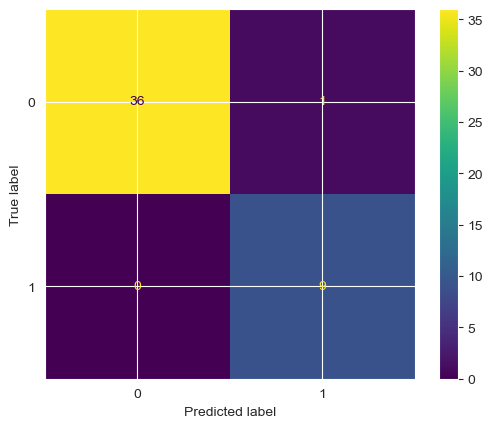

Accuracy: 0.9782608695652174 Precision: 0.9
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.90      1.00      0.95         9

    accuracy                           0.98        46
   macro avg       0.95      0.99      0.97        46
weighted avg       0.98      0.98      0.98        46



In [133]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Predict the test occurence of tumors

five_health_a = tumor_model.predict(five_health_X_validation)
print(len(five_health_a), 
     )

five_health_a_df = pd.DataFrame(five_health_a)


# make confusion matrix
cm = confusion_matrix(five_health_y_validation, five_health_a_df)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=clf.classes_
                             )
disp.plot()
plt.show()

from sklearn import metrics

Accuracy = metrics.accuracy_score(five_health_y_validation, five_health_a_df)
Precision = metrics.precision_score(five_health_y_validation, five_health_a_df)

print('Accuracy:',Accuracy, 'Precision:',Precision)

from sklearn.metrics import classification_report

print(classification_report(five_health_y_validation, five_health_a_df))

### C. Predicting Tumorogenesis with only the radiation data

##### Data processing

In [101]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
rad_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Irrad_Age_(months)',
                                           'Years_Since_Irrad', 'Current_Age_(years)', 'Tumor_(Y/N)']]
rad_health_df.head(10)



,ID,Dose_(Gy),Irrad_Age_(months),Years_Since_Irrad,Current_Age_(years),Tumor_(Y/N)
0,1423,0.00,NaN,NaN,9.947945,0
1,1484,0.00,NaN,NaN,19.276712,0
2,1574,7.55,52.9,13.358904,17.767123,1
3,1575,7.85,40.2,14.372603,17.726027,0
4,1576,8.05,51.4,6.723288,11.005479,1
5,1577,7.55,37.0,12.438356,15.520548,1
6,1578,7.20,39.4,12.010959,15.295890,0
7,1597,8.40,52.9,15.868493,20.273973,1
8,1611,7.55,46.4,12.090411,15.961644,1
9,1612,6.75,84.2,12.147945,19.161644,0


In [102]:
### Process data for ML
#make train/testdf
(rad_health_train_df, rad_health_test_df)= rad_health_df, rad_health_df


# label values extraction
rad_health_y=rad_health_train_df['Tumor_(Y/N)']
rad_health_X=rad_health_train_df.drop(['Tumor_(Y/N)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,rad_health_X[rad_health_X.columns[:1]].shape[1]))

print(cat_features)


#put the data into the pool
rad_health_pool = Pool(data=rad_health_X, label=rad_health_y, cat_features=cat_features)


#train tesr split - 30% test
rad_health_data= train_test_split(rad_health_X, rad_health_y, test_size=0.3, random_state=0)

#### The order of this matters###
rad_health_X_train, rad_health_X_validation, rad_health_y_train, rad_health_y_validation= rad_health_data

rad_health_train_pool = Pool(
    data = rad_health_X_train,
    label = rad_health_y_train,
    cat_features = cat_features
)

rad_health_validation_pool = Pool(
    data = rad_health_X_validation,
    label = rad_health_y_validation,
    cat_features = cat_features
)



[0]


iteritems is deprecated and will be removed in a future version. Use .items instead.


##### Model Formation

In [103]:
# Model for Tumor occurance 
# loss_function = logloss becuase it's binary

rad_tumor_model= CatBoostClassifier(iterations=200
                                    ,
    learning_rate=0.5,
    loss_function='Logloss',
    custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)


rad_tumor_model.fit(rad_health_X, 
           rad_health_y, 
           cat_features=cat_features, 
           verbose=500 #tells how many iterations to print
         )

### 2000 iters takes 6.7 secs and gives 0.0004025 loss

0:	learn: 0.4678788	total: 3.62ms	remaining: 721ms
199:	learn: 0.0052452	total: 181ms	remaining: 0us


##### Predictions

46


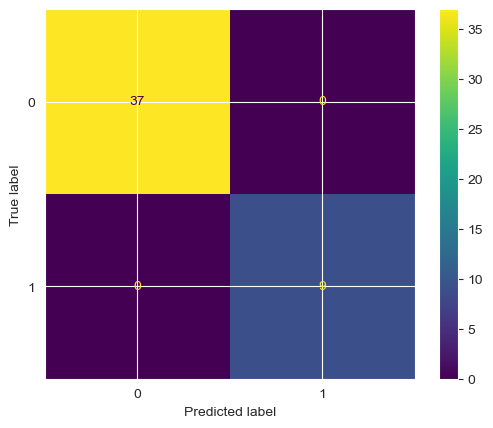

Accuracy: 1.0 Precision: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00         9

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



In [104]:
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Predict the test occurence of tumors

rad_health_a = rad_tumor_model.predict(rad_health_X_validation)
print(len(rad_health_a), 
     )
rad_health_a_df = pd.DataFrame(rad_health_a)



# make confusion matrix
cm = confusion_matrix(rad_health_y_validation, rad_health_a_df)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=clf.classes_
                             )
disp.plot()
plt.show()

from sklearn import metrics

Accuracy = metrics.accuracy_score(rad_health_y_validation, rad_health_a_df)
Precision = metrics.precision_score(rad_health_y_validation, rad_health_a_df)

print('Accuracy:',Accuracy, 'Precision:',Precision)

from sklearn.metrics import classification_report

print(classification_report(rad_health_y_validation, rad_health_a_df))


### 2000 iters gives 100%
### 1 iters gives 0.93 accuracy annd 0.5 precision
### 2 iters gives about the same
### for the low iters the loss is predicting the tumors, not predicting the healthy monkeys
### between 100 and 200 iters gives 100% for both

### Summary

## 1.d. Predicting dose 

#### Data Processing

In [105]:
#make single monkey
single_minbio_df.copy()
single_dose_df = single_minbio_df

#fill na values to 0
single_dose_df[['DOSE_(Gy)']]= single_dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)



#make multi monkey df
minbio_monkey_df.copy()
dose_df = minbio_monkey_df

#fill na values to 0
dose_df[['DOSE_(Gy)']]= dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)

dose_df['DOSE_(Gy)']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64

In [106]:
##### Multi Monkey ####

### Processing the data for ML

#make train/testdf
(dose_train_df, dose_test_df)= dose_df, dose_df


# label values extraction
dose_y=dose_train_df['DOSE_(Gy)']
dose_X=dose_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','DOSE_(Gy)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,dose_X[dose_X.columns[:4]].shape[1]))

print(cat_features)


#put the data into the pool
dose_pool = Pool(data=dose_X, label=dose_y, cat_features=cat_features)


#train tesr split - 30% test
dose_data= train_test_split(dose_X, dose_y, test_size=0.3, random_state=0)

#### The order of this matters###
dose_X_train, dose_X_validation, dose_y_train, dose_y_validation= dose_data

dose_train_pool = Pool(
    data = dose_X_train,
    label = dose_y_train,
    cat_features = cat_features
)

dose_validation_pool = Pool(
    data = dose_X_validation,
    label = dose_y_validation,
    cat_features = cat_features
)


[0, 1, 2, 3]


iteritems is deprecated and will be removed in a future version. Use .items instead.


In [107]:
##### Multi Monkey ####

### Processing the data for ML

#make train/testdf
(single_dose_train_df, single_dose_test_df)= single_dose_df, single_dose_df


# label values extraction
single_dose_y=single_dose_train_df['DOSE_(Gy)']
single_dose_X=single_dose_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','DOSE_(Gy)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,single_dose_X[single_dose_X.columns[:4]].shape[1]))

print(cat_features)


#put the data into the pool
single_dose_pool = Pool(data=single_dose_X, label=single_dose_y, cat_features=cat_features)


#train tesr split - 30% test
single_dose_data= train_test_split(single_dose_X, single_dose_y, test_size=0.3, random_state=0)

#### The order of this matters###
single_dose_X_train, single_dose_X_validation, single_dose_y_train, single_dose_y_validation= single_dose_data

single_dose_train_pool = Pool(
    data = single_dose_X_train,
    label = single_dose_y_train,
    cat_features = cat_features
)

single_dose_validation_pool = Pool(
    data = single_dose_X_validation,
    label = single_dose_y_validation,
    cat_features = cat_features
)


[0, 1, 2, 3]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [108]:
### Making a model with the same perameters but without the single monkey data
# regression for multiple monkey predicitons
dose_model= CatBoostRegressor(iterations=100,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

dose_model.fit(dose_X, 
           dose_y, 
           cat_features=cat_features, 
           verbose=100 #tells how many iterations to print
         )
### 2 iters gives R2 = 0.78 but way off
### 10 gives R2 = 0.92 but still funky
### 100 gives R2 = 0.98 and looking better

0:	learn: 1.8015170	total: 7.91ms	remaining: 783ms
99:	learn: 0.3432601	total: 409ms	remaining: 0us


#### Predictions


##### Multi Monkey Predictions

1366


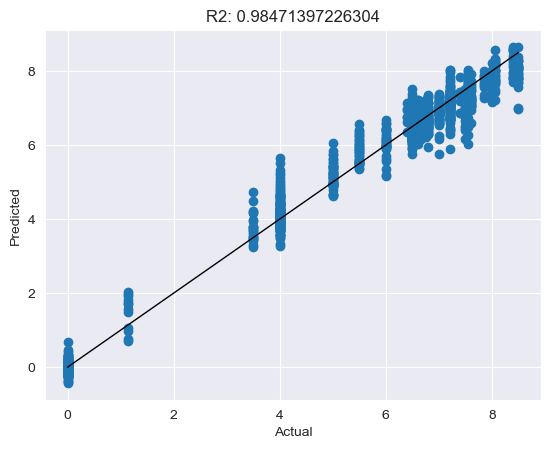

In [109]:
### Predicting the single monkey dose levels
## 2 iteration, 0.5 learning rate

dose_a = dose_model.predict(dose_X_validation)
print(len(dose_a), 
     )
dose_a_df = pd.DataFrame(dose_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(dose_y_validation, dose_a_df)


ax.plot([dose_y.min(), dose_y.max()], [dose_y.min(), dose_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(dose_y_validation, dose_a_df)))

plt.show()

##### Single Monkey

A little weird, figure out how to give the model only one row/line of data

1366


iteritems is deprecated and will be removed in a future version. Use .items instead.


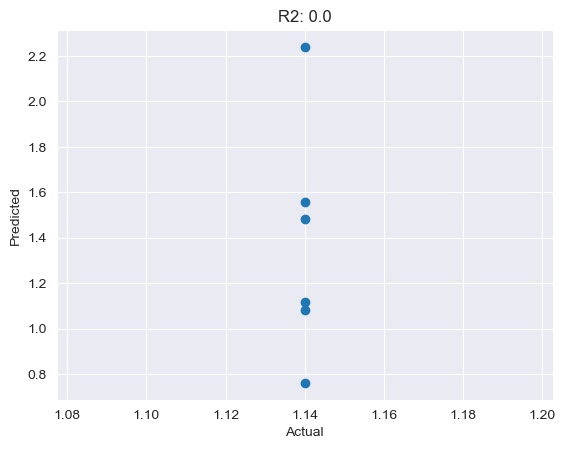

In [110]:
### Predicting the single monkey dose levels
## 2 iteration, 0.5 learning rate

single_dose_a = dose_model.predict(single_dose_X_validation)
print(len(dose_a), 
     )
single_dose_a_df = pd.DataFrame(single_dose_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(single_dose_y_validation, single_dose_a_df)


ax.plot([single_dose_y.min(), single_dose_y.max()], [single_dose_y.min(), single_dose_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(single_dose_y_validation, single_dose_a_df)))

plt.show()

#### Feature Analysis

##### Multi Monkey

In [111]:
# Find the feature importance for predicting the lmphocyte counts is a single monkey
dose_model.get_feature_importance(data=dose_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)

#MONTHS AT IRRAD may be beecause the protocols had a standdard age to irradiate

,Feature Id,Importances
0,MONTHS AT IRRAD,78.373332
1,MONTHS_SINCE_IRRAD,4.828723
2,DAYS_SINCE_IRRAD,2.651864
3,SEX,2.217122
4,AGE,1.883568
5,Mean_corpuscular_hemaglobin_(MCH_pg),1.730285
6,Hemocrit_(HCT_%),1.326405
7,Mean_corpuscular_volume_(MCV_fL),0.835481
8,PLATLET_COUNT_(K/uL),0.768381
9,Mean_corpuscular_hemaglobin_concentration_(MCH...,0.746726


##### Single Monkey

In [112]:
dose_model.get_feature_importance(data=single_dose_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)

,Feature Id,Importances
0,Hemocrit_(HCT_%),35.232249
1,Mean_corpuscular_hemaglobin_(MCH_pg),18.636849
2,Hemaglobin_(HGB_g/dL),14.508487
3,ABS_NEUT_(/uL),4.630418
4,AGE,3.569756
5,PLATLET_COUNT_(K/uL),3.119549
6,MONO_(%),3.037803
7,Mean_corpuscular_hemaglobin_concentration_(MCH...,2.834909
8,DAYS_SINCE_IRRAD,2.623971
9,Mean_corpuscular_volume_(MCV_fL),2.353940


#### Summary
We were able to accurately predict dose for the multi monkey data, but unsuccessful for the single monkey. This could be due to not giving the model properly formatted data, but is important for the first paper and as a diagnostic tool. The feature analysis seemed to produce feasible most important features for the accurate (multi monnkey) model.

# 2.) Clusterinng with dendogram

### Data processing for clustering

In [ ]:
minmod_health_monkey_df.copy()
clust_health_df = minmod_health_monkey_df

clust_health_df = clust_health_df.drop(['Irrad_Age_(months)','Years_Since_Irrad'],axis=1)
clust_health_df.head()


In [ ]:
clust_bio_df.columns

In [ ]:
minbio_monkey_df.copy()
clust_bio_df = minbio_monkey_df
clust_bio_df = clust_bio_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

clust_bio_df['IRRAD'] = clust_bio_df['IRRAD'].map({'Yes': 1,'No': 1})
clust_bio_df['SEX'] = clust_bio_df['SEX'].map({'F': 0,'M':1})


# NaN to 0
clust_bio_df[['DOSE_(Gy)','DAYS_SINCE_IRRAD',
       'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']]= clust_bio_df[['DOSE_(Gy)','DAYS_SINCE_IRRAD',
       'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']].fillna(0, #inplace=True
)



clust_bio_df.columns

In [ ]:
clust_health_df.copy()
small_health_df = clust_health_df[['ID','Time_Under_Observation_(yrs)','Dose_(Gy)',
                                   'Current_Age_(years)','Animal_Status']]
small_health_df.head(2)


In [ ]:
clust_bio_df.copy()
small_bio_df = clust_bio_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD',
       'MONTHS AT IRRAD', 'DOSE_(Gy)', 'AGE']]
small_bio_df.head(2)


In [ ]:
clust_bio_df.copy()
small_cell_df = clust_bio_df[['ID','NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)']]

small_cell_df.head(2)

In [ ]:
# Clustering based on the health statuses of the monkey
sns.clustermap(clust_health_df
              )

sns.clustermap(small_health_df
              )


In [ ]:
small_cell_df.copy()
float_cell_df = small_cell_df
float_cell_df['ID'] = float_cell_df['ID'].astype(float)

In [ ]:
# Clustering based on the bio data of the monkey


sns.clustermap(small_cell_df
              )

In [ ]:
#### the clustering is a real challenge, I tried to give different part of the data,
#### I tried to convert the types of data passed, I think that binary data doesn't cluster well

# 3.) Combining data
Fusing the biomarker and health data in the following ways for more robust predicitons/pattern recognition:

1.) Non-datetime biomarker data with the binary health outcome data

2.) Datetime biomarker and health outcome data

3.) Datetime biomarker and health coutcome data with the more subjective text

## a.) Datetime biomarker and health outcome data
 

## Concatonating data
Pandas has a .join(), .merge(), and .concat() methods

Need to either delete or ovelap the ID, Dose_(Gy), Irrad_Age_(months), Years_Since_Irrad, AGE, and the equivilents.

Issue: not all monkeys are accounted for in the health data, and there are far more samples in the bio data - make sure it fills down??? based on date???


In [ ]:
minbio_monkey_df.join(minmod_health_monkey_df, on='ID',rsuffix='_right')

## b.) Datetime biomarker and health outcome data



## c.) Datetime biomarker and health coutcome data with the more subjective text

# 4.) Dimentionality reduction
Can I initially reduce the number of features for faster training and better vizualization with the same amount of power?

Using Non-negative matrix factorization (NMF) because it seemed well used and effective
 - however, has to be linearly seperatable

Also using t-Distributed Stochastic Neighbor Embedding (t-SNE) because it works well for non-linear data

Articel on different techniques:
https://neptune.ai/blog/dimensionality-reduction#:~:text=Advantages%20and%20disadvantages-,What%20is%20dimensionality%20reduction%3F,variables%20are%20also%20called%20features.

Sklearn NMF https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

Sklearn TSNE https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


In [ ]:
#get the single monkey data in a form that can be understood by the NMF and TSNE - no text or datetime

single_red_df = single_monkey_df.copy()
single_red_df = single_red_df.drop(['Species','SEX', 'TYPE','IRRAD_DATE','DOB','SAMPLE_DATE',], axis =1)
#single_red_df.head(2)

#Turn 'Yes' and 'No' to 1 & 0 - numerical
single_red_df['IRRAD'] = single_red_df['IRRAD'].map({'Yes': 1, 'No': 0})


single_red_df.head(2)

In [ ]:
from sklearn.manifold import TSNE

#17 is the max for perplexityin this instance
monkey_tsne = TSNE(n_components=2, 
                   perplexity=17
                   ).fit_transform(single_red_df)


In [ ]:
df_subset1 = monkey_tsne[:,0]
df_subset2 = monkey_tsne[:,1]

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_subset1, y=df_subset2,
    #hue="y",
    palette=sns.color_palette("hls", 10),
    #data=df_subset,
    legend="full",
    alpha=1
)

## UMAP
Want to try UMAP with the health outcome and combined data

In [ ]:
# Same setup as from the docs example: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap.plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import umap
reducer = umap.UMAP()



print('Setup Complete')

In [ ]:
#need to scale the vales to z-scores to get them all on the same page

#Make df with the blood analytics with no missing values - NaN as 0, see if there's a better way
minmod_health_monkey_df.copy()
healthumap_df = minmod_health_monkey_df.fillna(0)

#healthumap_df.head()

#Scale the blood to z-scores
healthumap_df = healthumap_df.values
scaled_healthumap_df = StandardScaler().fit_transform(healthumap_df)

In [ ]:
# Want it to be (n, 2) for UMAP to work
embedding = reducer.fit_transform(scaled_healthumap_df)
embedding.shape

In [ ]:
# Simply visualize the UMAP
plt.scatter(embedding[:, 0], 
            embedding[:, 1], 
            c=minmod_health_monkey_df.ID, 
            cmap='Spectral', 
            s=10
           )

#show the spiderweb
#umap.plot.connectivity(mapper, edge_bundling='hammer')

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Health Outcome of the Monkeys', fontsize=24);

## Interactive Health outcome UMAP

In [ ]:
# Set up interactive loading of 
from io import BytesIO
from PIL import Image
import base64
import bokeh

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

#This part has to go below up above
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

In [ ]:
umap1_df = pd.DataFrame(embedding, columns=('x', 'y'))

datasource = ColumnDataSource(umap1_df)
#color_mapping = CategoricalColorMapper(factors=minmod_health_monkey_df['ID'],
#                                       palette='Turbo256')




plot_figure = figure(
    title='UMAP projection of the Health outcome dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=umap1_df,
    #color=dict(field='digit', #transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)

show(plot_figure)

### It works, but the number of points is so large it gives them all grey colors, might work with just monkeys ###

# 5.) Automate cycling through feature predicitons
Instead of seting up a single label-train dynamic, can I predict every single feature based on the same data?

# Conclusions